# CS4035 - Cyber Data Analytics
## Lab 1 - Fraud data

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 1 contains 5 main questions, including the bonus. Write the code or explanation below each sub question. For the explanations, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) The libraries needed to run this file. Except for numpy, scikit-learn, pandas, matplotlib

Your peers should be able to use the readme section for instructions and be able to run this file. 

Make sure to keep your answers concise. Maximum number of words is 1000, which you can count with the code below. (You can add around 600 words since we start at around 400).

In [77]:
# If this cell does not work try running `pip install nbformat`

import io
# from IPython 
import nbformat

nb = nbformat.read("Lab1.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 976


## Group Number : 1

## Student 1 
### Name : Amar Mesic
### ID : 5106117

## Student 2
### Name : Athanasios Georgoutsos
### ID : 6015883

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [52]:
# Libraries used in this lab assignment

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import re

# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# NOTE: The following code defines the paths of the data files
# Modify with your own paths OR
# create a directory with the name "cda-lab-1-credit-card-fraud" in the same directory 
# as this .ipynb file and place the data files in it

train_path = 'cda-lab-1-credit-card-fraud/train_data.csv'
test_path = 'cda-lab-1-credit-card-fraud/test_data.csv'

## 1. Visualization task – 1 A4

### Basic Preprocessing

In [3]:
# Train data loading
df = pd.read_csv(train_path)
df.head()

,Id,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label
0,1,GB,mccredit,546097.0,4500.0,GBP,GB,Ecommerce,True,1,UKAccount,email132571,ip123779,card250169,0
1,2,GB,mcdebit,557349.0,3395.0,GBP,GB,Ecommerce,True,1,UKAccount,email312302,ip298387,card14235,0
2,3,GB,mccredit,542011.0,3895.0,GBP,GB,Ecommerce,True,1,UKAccount,email255027,ip260053,card31944,0
3,4,GB,visadebit,465943.0,15345.0,GBP,GB,ContAuth,False,0,UKAccount,email283167,ip54851,card120871,0
4,6,GB,visadebit,475127.0,5095.0,GBP,GB,Ecommerce,True,1,UKAccount,email325263,ip203929,card208017,0


In [4]:
# Prepare card id and ip id for plotting
# Preprocessing pipeline adjusted from W1_Visuals.ipynb

# 1.Card ID
card_enc = LabelEncoder()
card_enc.fit(df['card_id'])
df['card_id'] = card_enc.transform(df.card_id)

# 2.IP ID
ip_enc = LabelEncoder()
ip_enc.fit(df['ip_id'])
df['ip_id'] = ip_enc.transform(df.ip_id)

#Encoding, Cleaning the data
df.loc[df['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
df.loc[df['issuercountrycode'].isna(),'issuercountrycode'] = 'ZZ'
df.loc[df['shoppercountrycode'].isna(),'shoppercountrycode'] = 'ZZ'

unique_issuer_cc = df['issuercountrycode'].unique()
unique_shopper_cc = df['shoppercountrycode'].unique()
both = np.append(unique_issuer_cc, unique_shopper_cc)
df_countrycodes = pd.DataFrame(both)
unique_codes = df_countrycodes[0].unique()
enc = LabelEncoder()
enc.fit(unique_codes)
df['issuercountrycode'] = enc.transform(df.issuercountrycode)
df['shoppercountrycode'] = enc.transform(df.shoppercountrycode)
def conv(row):
    currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                     "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                     "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                     "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                     "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                     "CNY": 7.5541, "SEK": 10.635}
    return row['amount'] / (currency_dict[row['currencycode']]*100)

df['amount_eur'] = df.apply(lambda x: conv(x), axis=1)


enc1 = LabelEncoder()
enc1.fit(df['txvariantcode'])
df['txvariantcode'] = enc1.transform(df.txvariantcode)

enc2 = LabelEncoder()
enc2.fit(df['currencycode'])
df['currencycode'] = enc2.transform(df.currencycode)

enc3 = LabelEncoder()
enc3.fit(df['shopperinteraction'])
df['shopperinteraction'] = enc3.transform(df.shopperinteraction)

df['accountcode'] = df['accountcode'].apply(lambda x: re.sub('Account','',x))
df['accountcode_cc'] = 0
df.loc[(df['accountcode'] == 'UK'),'accountcode_cc'] = 'GB'
df.loc[(df['accountcode'] == 'Mexico'),'accountcode_cc'] = 'MX'
df.loc[(df['accountcode'] == 'Sweden'),'accountcode_cc'] = 'SE'
df.loc[(df['accountcode'] == 'APAC'),'accountcode_cc'] = 'APAC'

enc4 = LabelEncoder()
enc4.fit(df['accountcode'])
df['accountcode'] = enc4.transform(df.accountcode)

### Better to use one-hot encoding, very few categories
enc5 = LabelEncoder()
enc5.fit(df['cardverificationcodesupplied'])
df['cardverificationcodesupplied'] = enc5.transform(df.cardverificationcodesupplied)

df.loc[df['mail_id'].str.contains('na',case=False),'mail_id'] = 'email99999'

enc6 = LabelEncoder()
enc6.fit(df['mail_id'])
df['mail_id'] = enc6.transform(df.mail_id)

df.loc[df['cvcresponsecode'] > 2,'cvcresponsecode'] = 3

#Feature Engineering
df['countries_equal'] = (df['shoppercountrycode'] == df['issuercountrycode'])
df.loc[df['countries_equal'] == False,'countries_equal'] = 0
df.loc[df['countries_equal'] == True,'countries_equal'] = 1

C:\Users\Thanos\AppData\Local\Temp\ipykernel_7760\929892654.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'GB' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df['accountcode'] == 'UK'),'accountcode_cc'] = 'GB'
C:\Users\Thanos\AppData\Local\Temp\ipykernel_7760\929892654.py:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[df['countries_equal'] == False,'countries_equal'] = 0


In [5]:
# Print columns
print('df columns: ', df.columns)

fraudulent_df = df.query('label==1')
normal_df = df[df['label'] == 0]

# Print number of records for each class and in total
print('Fraudulent transactions: ', fraudulent_df.shape[0])
print('Normal transactions: ', normal_df.shape[0])
print('all transactions: ', df.shape[0])

df columns:  Index(['Id', 'issuercountrycode', 'txvariantcode', 'bin', 'amount',
       'currencycode', 'shoppercountrycode', 'shopperinteraction',
       'cardverificationcodesupplied', 'cvcresponsecode', 'accountcode',
       'mail_id', 'ip_id', 'card_id', 'label', 'amount_eur', 'accountcode_cc',
       'countries_equal'],
      dtype='object')
Fraudulent transactions:  276
Normal transactions:  189352
all transactions:  189628


In [21]:
# Check Dataframe after preprocessing
df.head()

# Account code distribution
# 0: APAC, 1: Mexico, 2: Sweden, 3: Great Britain

,Id,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label,amount_eur,accountcode_cc,countries_equal
0,1,49,2,546097.0,4500.0,1,49,1,1,1,3,17805,12538,105460,0,52.175123,GB,1
1,2,49,3,557349.0,3395.0,1,49,1,1,1,3,115620,107432,29882,0,39.363232,GB,1
2,3,49,2,542011.0,3895.0,1,49,1,1,1,3,84651,87293,123743,0,45.160467,GB,1
3,4,49,8,465943.0,15345.0,1,49,0,0,0,3,99845,147089,14712,0,177.917169,GB,1
4,6,49,8,475127.0,5095.0,1,49,1,1,1,3,122624,56390,75841,0,59.073834,GB,1


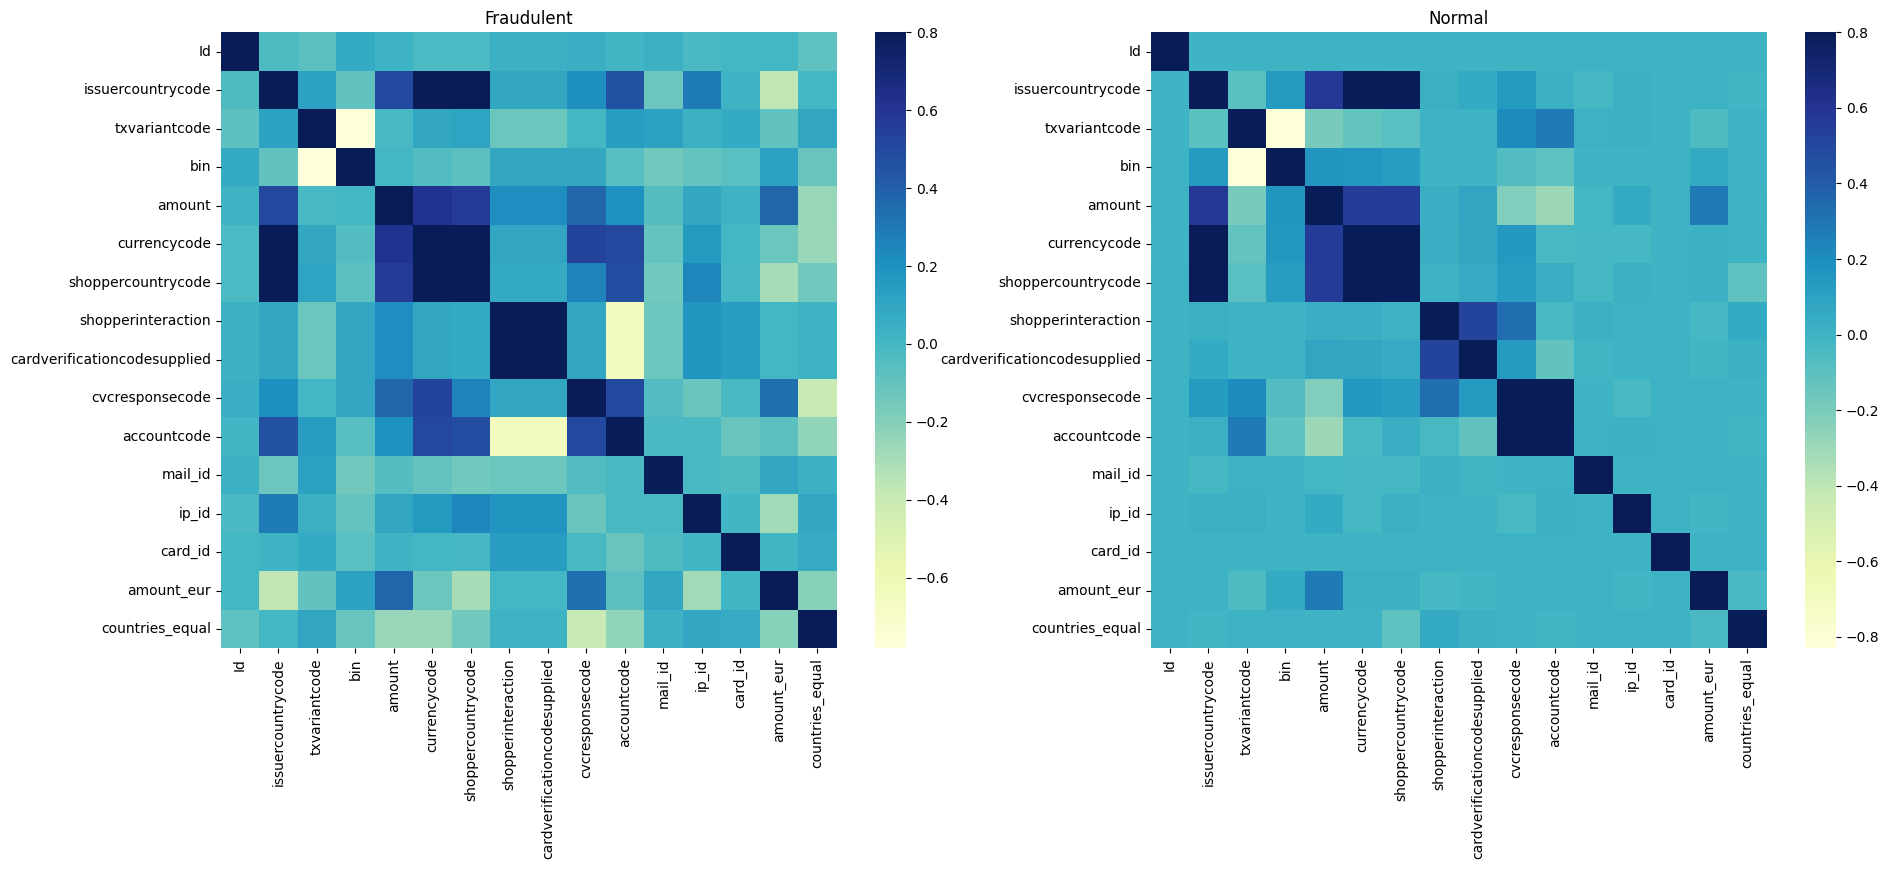

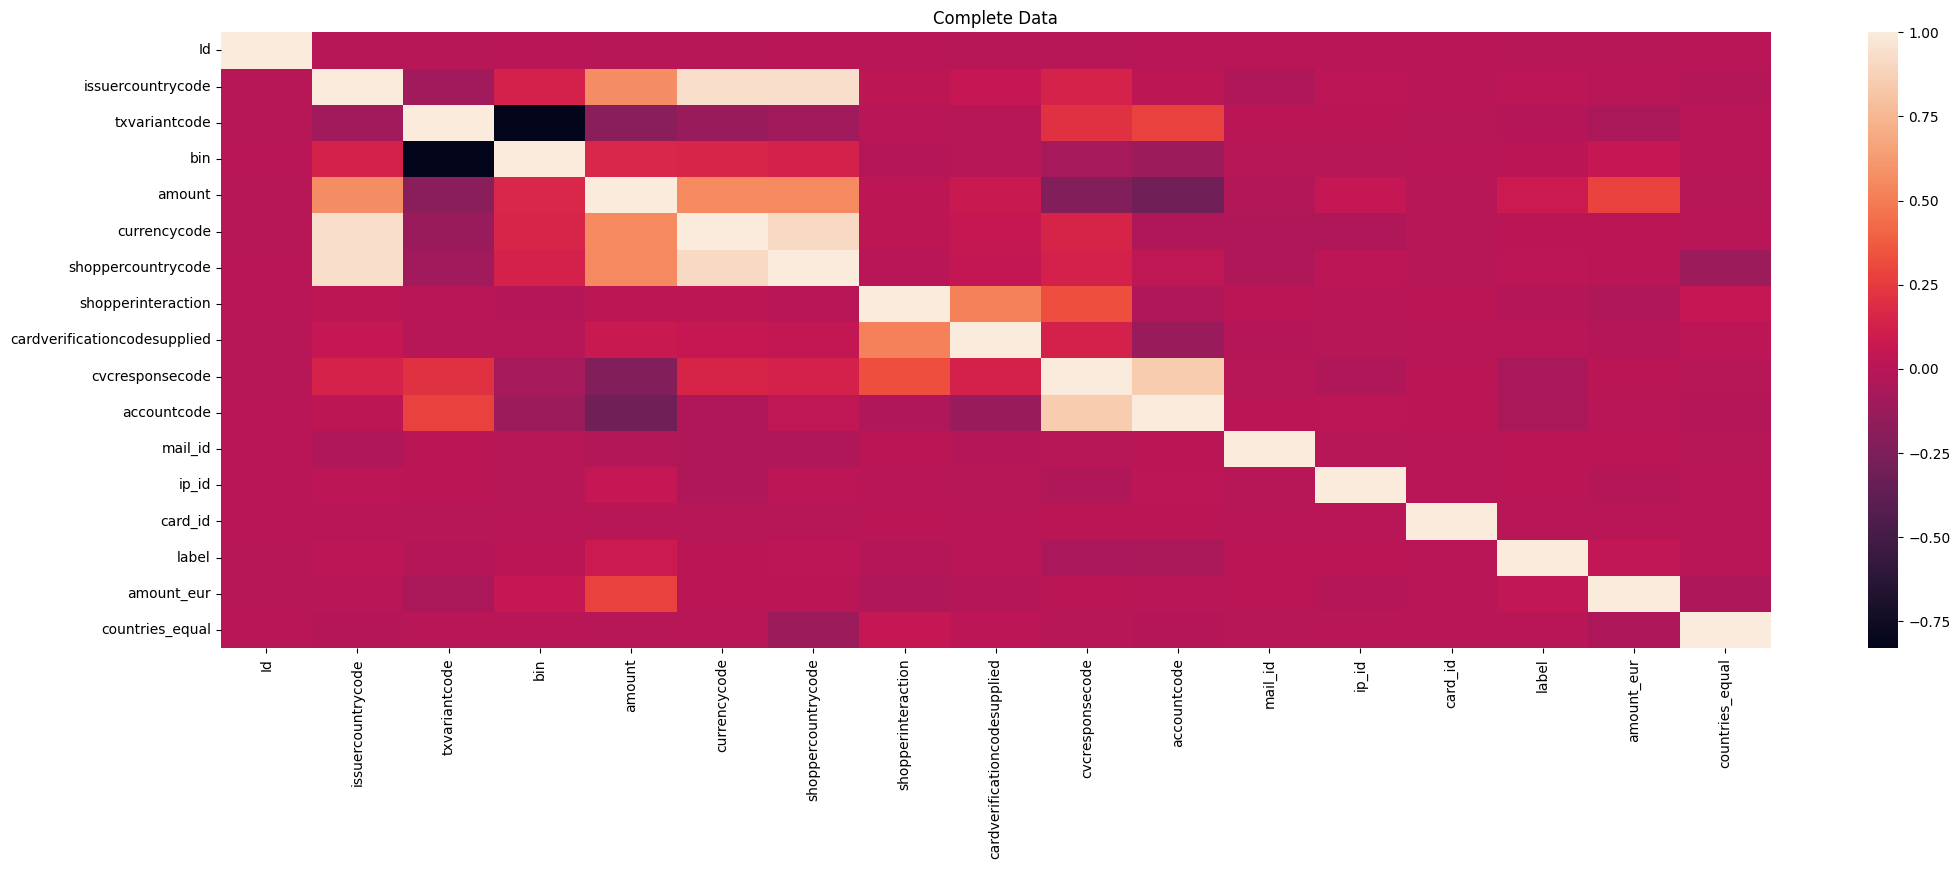

In [7]:
# Basic plot, heatmaps of the correlation matrices
# Adjusted from W1_Visuals.ipynb

#correlation matrices
f, (ax1, ax2) = plt.subplots(1,2,figsize =(22, 8))

sns.heatmap(df.query('label==1').drop(['label', 'accountcode_cc'], axis=1).corr(), vmax = .8, square=True, ax = ax1, cmap = 'YlGnBu')
ax1.set_title('Fraudulent')

sns.heatmap(df.query('label==0').drop(['label', 'accountcode_cc'], axis=1).corr(), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu')
ax2.set_title('Normal')

plt.show()

f, (ax1) = plt.subplots(1,figsize =(25, 8))
sns.heatmap(df.drop(['accountcode_cc'], axis=1).corr())
ax1.set_title('Complete Data')
plt.show()

### 1a. Plot visulations 

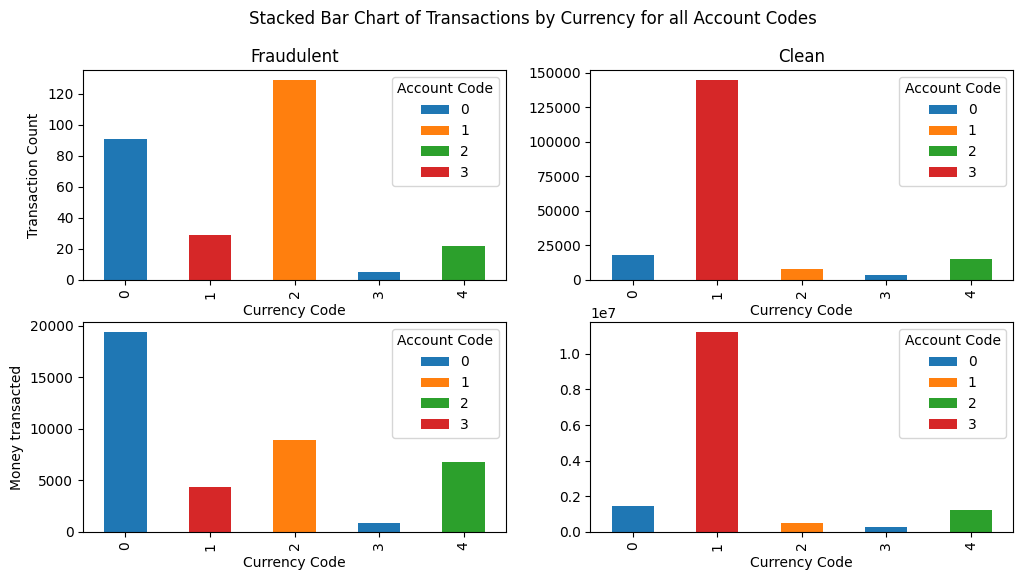

In [12]:
# Plot 1: Distribution of transactions by account code

# Create a contingency table
table_all = pd.crosstab(df['currencycode'], df['accountcode'])
table_fraudulent = pd.crosstab(fraudulent_df['currencycode'], fraudulent_df['accountcode'])
table_normal = pd.crosstab(normal_df['currencycode'], normal_df['accountcode'])
table_fraudulent_amount = pd.crosstab(fraudulent_df['currencycode'], fraudulent_df['accountcode'], values=df['amount_eur'], aggfunc='sum')
table_normal_amount = pd.crosstab(normal_df['currencycode'], normal_df['accountcode'], values=df['amount_eur'], aggfunc='sum')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))  # Create a figure and a 1x2 subplot grid
fig.suptitle('Stacked Bar Chart of Transactions by Currency for all Account Codes')

# Plot a stacked bar chart
table_fraudulent.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_title('Fraudulent')
ax1.set_xlabel('Currency Code')
ax1.set_ylabel('Transaction Count')
ax1.legend(title='Account Code')


table_normal.plot(kind='bar', stacked=True, ax=ax2)
ax2.set_title('Clean')
ax2.set_xlabel('Currency Code')
# ax2.set_ylabel('Transaction Count')
ax2.legend(title='Account Code')

table_fraudulent_amount.plot(kind='bar', stacked=True, ax=ax3)
ax3.set_xlabel('Currency Code')
ax3.set_ylabel('Money transacted')
ax3.legend(title='Account Code')


table_normal_amount.plot(kind='bar', stacked=True, ax=ax4)
ax4.set_xlabel('Currency Code')
ax4.legend(title='Account Code')

plt.show()

accountcode                   0  1  2  3
cardverificationcodesupplied            
0                             0  0  0  3
1                             5  5  3  2


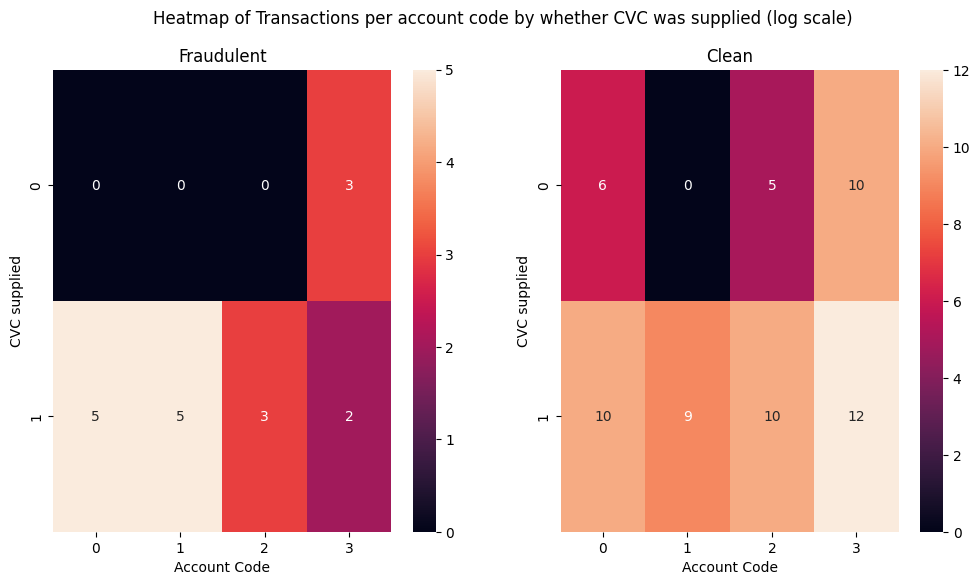

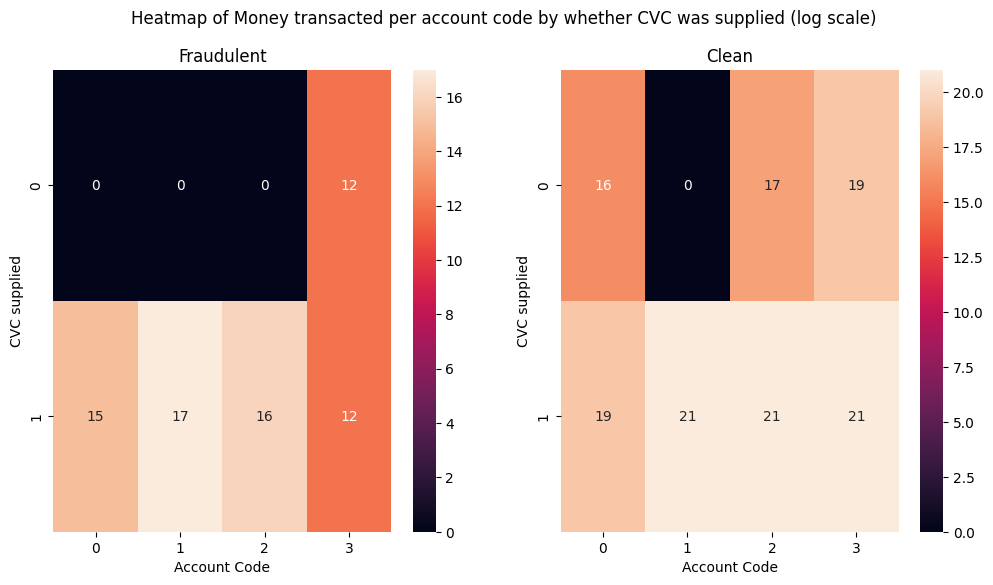

In [14]:
# Plot 2: Heatmap of transactions and amounts transacted, per account code, by whether CVC was supplied
# using log scale

table_all = pd.crosstab(df['cardverificationcodesupplied'], df['accountcode'])
table_fraudulent = pd.crosstab(fraudulent_df['cardverificationcodesupplied'], fraudulent_df['accountcode']).map(lambda x: np.log(x + 1)).map(round)
table_normal = pd.crosstab(normal_df['cardverificationcodesupplied'], normal_df['accountcode']).map(lambda x: np.log(x + 1)).map(round)
table_fraudulent_amount = pd.crosstab(fraudulent_df['cardverificationcodesupplied'], fraudulent_df['accountcode'], values=df['amount'], aggfunc='sum').fillna(1).map(np.log).map(round)
table_normal_amount = pd.crosstab(normal_df['cardverificationcodesupplied'], normal_df['accountcode'], values=df['amount'], aggfunc='sum').fillna(1).map(np.log).map(round)

# sns.heatmap(table_all, annot=True, fmt='d')

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))  # Create a figure and a 1x2 subplot grid
fig.suptitle('Heatmap of Transactions per account code by whether CVC was supplied (log scale)')

# Plot a stacked bar chart
sns.heatmap(table_fraudulent, annot=True, fmt='d', ax=ax1)
ax1.set_title('Fraudulent')
ax1.set_xlabel('Account Code')
ax1.set_ylabel('CVC supplied')

sns.heatmap(table_normal, annot=True, fmt='d', ax=ax2)
ax2.set_xlabel('Account Code')
ax2.set_ylabel('CVC supplied')
ax2.set_title('Clean')



fig2, (ax3, ax4) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))  # Create a figure and a 1x2 subplot grid
fig2.suptitle('Heatmap of Money transacted per account code by whether CVC was supplied (log scale)')


sns.heatmap(table_fraudulent_amount, annot=True, fmt='g', ax=ax3)
ax3.set_title('Fraudulent')
ax3.set_xlabel('Account Code')
ax3.set_ylabel('CVC supplied')


sns.heatmap(table_normal_amount, annot=True, fmt='g', ax=ax4)
ax4.set_title('Clean')
ax4.set_xlabel('Account Code')
ax4.set_ylabel('CVC supplied')

plt.show()

cvcresponsecode
0    32321.134644
1     7986.037526
Name: amount_eur, dtype: float64
cvcresponsecode
0    2.675360e+06
1    1.197988e+07
2    8.802523e+02
3    1.381156e+04
Name: amount_eur, dtype: float64


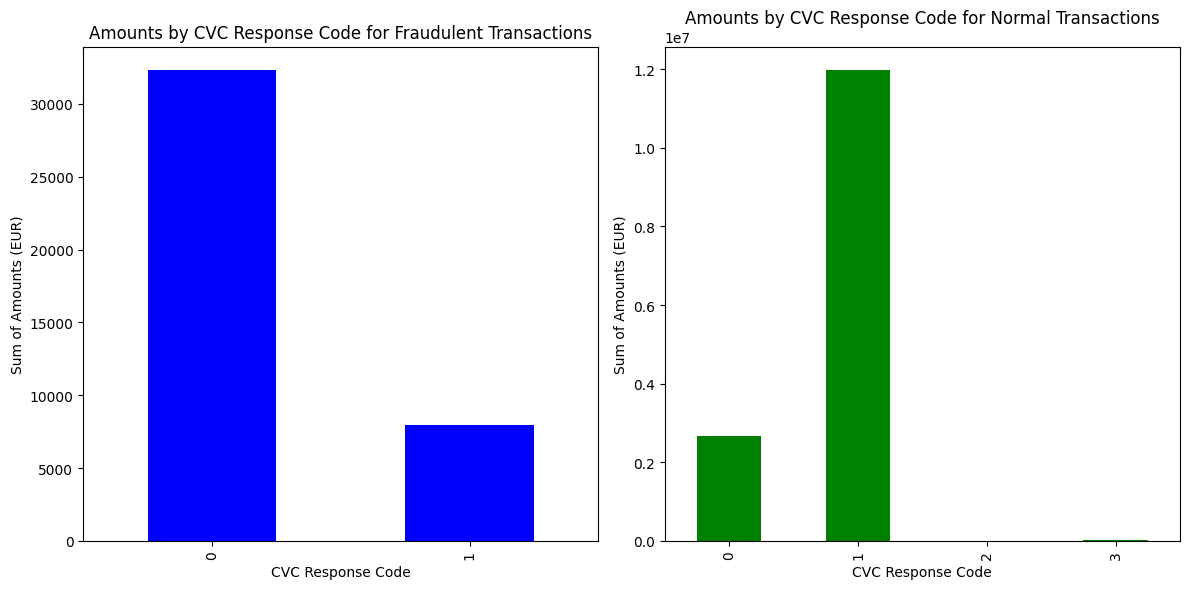

In [17]:
# Plot 3: Amounts of money transacted by whether cvc was supplied

# Correlation between amount of euros transacted and the cvc response code
sum_fraudulent = fraudulent_df.groupby('cvcresponsecode')['amount_eur'].sum()
sum_normal = normal_df.groupby('cvcresponsecode')['amount_eur'].sum()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot the bar chart for the first DataFrame
sum_fraudulent.plot(kind='bar', ax=ax[0], color='blue')
ax[0].set_title('Amounts by CVC Response Code for Fraudulent Transactions')
ax[0].set_xlabel('CVC Response Code')
ax[0].set_ylabel('Sum of Amounts (EUR)')

# Plot the bar chart for the second DataFrame
sum_normal.plot(kind='bar', ax=ax[1], color='green')
ax[1].set_title('Amounts by CVC Response Code for Normal Transactions')
ax[1].set_xlabel('CVC Response Code')
ax[1].set_ylabel('Sum of Amounts (EUR)')

plt.tight_layout()
plt.show()

### 1b. Describe the visualizations and provide relavant explanations of features and relations.

#### Plot 1: Stacked bar chart of transactions by currency for all account codes
Our first observation is that **all accounts deal strictly in the local currency of their region**, since we would have multiple bars for each account code. Then, we can see that money circulation closely follows the number of transactions, with the exception of the case of fraudulent mexican transactions. A key observation is that **fraud is more common in mexican and australian accounts, while the majority of the normal transactions is with british accounts.** This could prove very useful for our classifiers later on, as they could assign higher fraud probabilities to suspiscious transactions from these regions.

#### Plot 2: Heatmap of transactions and monetary circulation per account code by whether CVC was supplied (log scale)
Again, money transferred closely follow the number of transactions. For fraudulent transactions, CVC was always supplied in Australia, Mexico and Sweden, while half of the frauds in UK did not supply a CVC. On the other hand, for normal transactions, CVC was always supplied in Mexico, sometimes not supplied in Australia and Sweden, and often not supplied in the UK. This means that **we cannot use the CVC supplied feature to discriminate between frauds and clean transactions in all account codes, but Australia and Sweden**, where surprisingly CVC not supplied indicates clean transactions from the train data.

#### Plot 3: Bar chart of CVC response code types by amount of money circulated
We observe that **for fraudulent transactions, CVC response was either unknown or positive, where for unknown responses 4 times more money were transferred**. Then, we turn our attention to **normal transactions, where CVC response was rarely negative or not checked, and 3 times more money were transferred with positive responses than unknown**. This difference could also serve our classifiers later.

## 4. Classification task – 2 A4

### Additional Data Preprocessing

In [23]:
# check dataframe
df.head()

,Id,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label,amount_eur,accountcode_cc,countries_equal
0,1,49,2,546097.0,4500.0,1,49,1,1,1,3,17805,12538,105460,0,52.175123,GB,1
1,2,49,3,557349.0,3395.0,1,49,1,1,1,3,115620,107432,29882,0,39.363232,GB,1
2,3,49,2,542011.0,3895.0,1,49,1,1,1,3,84651,87293,123743,0,45.160467,GB,1
3,4,49,8,465943.0,15345.0,1,49,0,0,0,3,99845,147089,14712,0,177.917169,GB,1
4,6,49,8,475127.0,5095.0,1,49,1,1,1,3,122624,56390,75841,0,59.073834,GB,1


In [24]:
"""
1. Scale numeric features (bin, amount, amount_eur)
    and also some categorical features (mail_id, ip_id, card_id)
    using MinMaxScaler
"""

scaler = MinMaxScaler()
df[['bin', 'amount', 'amount_eur', 'mail_id', 'ip_id', 'card_id']] = scaler.fit_transform(df[['bin', 'amount', 'amount_eur', 'mail_id', 'ip_id', 'card_id']])

In [25]:
# keep features and labels for training
X = df.drop(['label', 'accountcode_cc'], axis=1)
y = df['label']

### 10-Fold  Split - Oversampling - Training/Evaluation Function

In [35]:
# function that performs K-Fold split for cross-validation
# and returns train and test data for each fold in lists
def kfold_split(X, y, n_splits=10):
    # use Stratified K-Folds cross-validation to split the data into 10 folds
    skf = StratifiedKFold(n_splits=n_splits)

    train_folds = []
    test_folds = []

    # keep train and test data for each fold, as using Startified K-Folder
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        # print(f"Fold {i+1}: Train: {len(train_index)}, Test: {len(test_index)}")
        train_folds.append((X.iloc[train_index], y.iloc[train_index]))
        test_folds.append((X.iloc[test_index], y.iloc[test_index]))
    return train_folds, test_folds

In [36]:
# get the train and test data for each fold
train_folds, test_folds = kfold_split(X, y, 10)

# NOTE: Using SMOTE to synthesize data will require longer training times
# For this reason, we have commented out the code below and provided
# an undersampling process instead. If you want to use SMOTE, uncomment the code below
# and comment out the undersampling part

"""
for i, (X_train, y_train) in enumerate(train_folds):
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    train_folds[i] = (X_resampled, y_resampled)
"""

for i, (X_train, y_train) in enumerate(train_folds):
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
    train_folds[i] = (X_resampled, y_resampled)


In [39]:
# function to evaluate models for K-folds
# returns accuracies and probabilities of fraudulent transactions
# for test set of each fold

def evaluate_model_k_folds(train_folds, test_folds, models):
    """
    Evaluate model using K-Fold cross-validation
    train_folds: list of train data for each fold
    test_folds: list of test data for each fold
    models: list of identical models to evaluate for each fold
    """


    # calculate accuracy and probabilities of fraudulent transactions
    # for each fold
    accuracies = []
    probs = []

    for i, (X_train, y_train) in enumerate(train_folds):
        
        clf = models[i]

        # fit the model
        X_test, y_test = test_folds[i]
        clf.fit(X_train, y_train)

        # predict and calculate accuracy
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        print(f"Fold {i+1} Accuracy: {accuracy:.5f}")

        # calculate probabilities of fraudulent transactions for ROC curve
        y_probs = clf.predict_proba(X_test)[:, 1]
        probs.append(y_probs)

    return accuracies, probs

### Black-Box Model: Random Forest

In [40]:
# NOTE: Running this cell with SMOTE for synthesizing data, takes approximately 16 minutes and 40 seconds
# If you want to test it faster, you can do the undersampling instead of SMOTE two code cells above

rf_list = []
for i in range(10):
    rf_list.append(RandomForestClassifier(random_state=42))

# Evaluate the model using K-Folds
rf_accuracies, rf_probs = evaluate_model_k_folds(train_folds, test_folds, rf_list)

Fold 1 Accuracy: 0.85725
Fold 2 Accuracy: 0.86300
Fold 3 Accuracy: 0.86410
Fold 4 Accuracy: 0.88773
Fold 5 Accuracy: 0.87075
Fold 6 Accuracy: 0.87560
Fold 7 Accuracy: 0.86547
Fold 8 Accuracy: 0.87423
Fold 9 Accuracy: 0.86647
Fold 10 Accuracy: 0.86647


### White-Box Model: Logistic Regression

In [47]:
# NOTE: Running this cell with SMOTE for synthesizing data, takes much longer than 20 minutes
# If you want to test it faster, you can do the undersampling instead of SMOTE two code cells above

lr_list = []
for i in range(10):
    lr_list.append(LogisticRegression(max_iter=10000, random_state=42))

# Evaluate the model using K-Folds
lr_accuracies, lr_probs = evaluate_model_k_folds(train_folds, test_folds, lr_list)

Fold 1 Accuracy: 0.80404
Fold 2 Accuracy: 0.79323
Fold 3 Accuracy: 0.79397
Fold 4 Accuracy: 0.80430
Fold 5 Accuracy: 0.80678
Fold 6 Accuracy: 0.80942
Fold 7 Accuracy: 0.80314
Fold 8 Accuracy: 0.80483
Fold 9 Accuracy: 0.77698
Fold 10 Accuracy: 0.80118


### 4a. Print relevant plots and metrics with clear headings.

##### Functions for metrics and plots

In [49]:
# function to plot ROC curve for each of K-folds
# and print the average and std of AUC scores for all folds
def plot_roc_curve(y_probs, y_test, title):
    """
    Plot the ROC curve for the given test labels and predicted labels
    
    Parameters:
    y_probs: list of probabilities of fraudulent transactions
    y_test: test labels
    """
    
    # Plot the ROC curve
    plt.figure(figsize=(8, 6))

    auc_scores = []

    for i in range(len(y_probs)):
        # Compute the ROC curve and AUC score
        fpr, tpr, _ = roc_curve(y_test[i], y_probs[i])
        auc_scores.append(auc(fpr, tpr))

        plt.plot(fpr, tpr)

    print(f"Mean AUC: {np.mean(auc_scores):.5f}")
    print(f"Std AUC: {np.std(auc_scores):.5f}")

    # plotting details
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.grid()
    plt.show()

In [53]:
# function to plot Precision-Recall curve for each of K-folds
# and print the average precision score for all folds
def plot_precision_recall_curve(y_probs, y_test, title):
    """
    Plot the Precision-Recall curve for the given test labels and predicted labels
    
    Parameters:
    y_probs: list of probabilities of fraudulent transactions
    y_test: test labels
    """
    
    # Plot the Precision-Recall curve
    plt.figure(figsize=(8, 6))

    for i in range(len(y_probs)):
        # Compute the Precision-Recall curve
        precision, recall, _ = precision_recall_curve(y_test[i], y_probs[i])

        plt.plot(recall, precision)

    # Compute the average precision score
    avg_precision = average_precision_score(np.concatenate(y_test), np.concatenate(y_probs))
    print(f"Average Precision: {avg_precision:.5f}")

    # plotting details
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.grid()
    plt.show()

##### Black-box Random Forest: ROC and Precision-Recall curves

Mean AUC: 0.94858
Std AUC: 0.01138


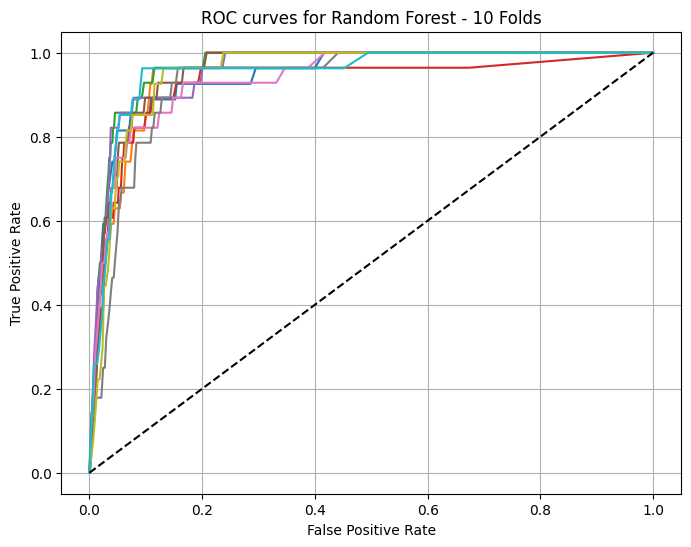

In [50]:
plot_roc_curve(rf_probs, [y_test for _, y_test in test_folds], "ROC curves for Random Forest - 10 Folds")

Average Precision: 0.02380


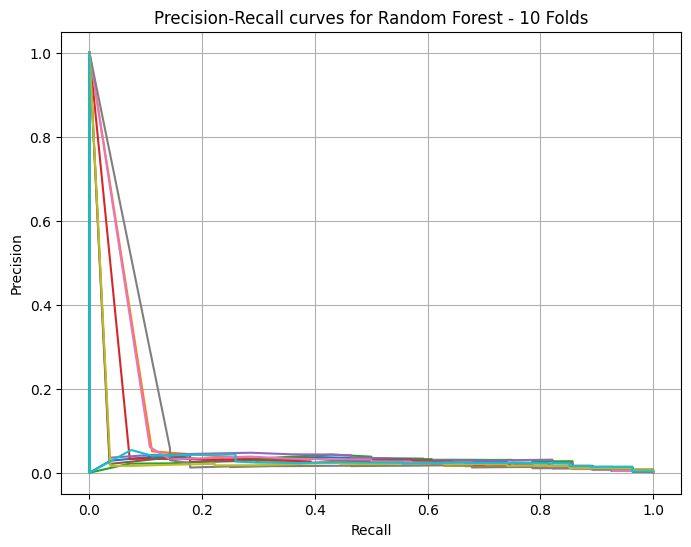

In [54]:
plot_precision_recall_curve(rf_probs, [y_test for _, y_test in test_folds], "Precision-Recall curves for Random Forest - 10 Folds")

##### White-box Logistic Regression: ROC and Precision-Recall curves

Mean AUC: 0.89814
Std AUC: 0.02034


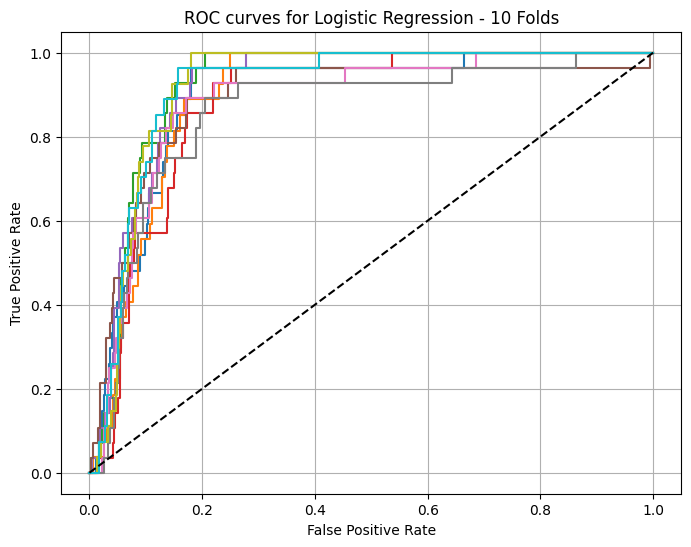

In [51]:
plot_roc_curve(lr_probs, [y_test for _, y_test in test_folds], "ROC curves for Logistic Regression - 10 Folds")

Average Precision: 0.00801


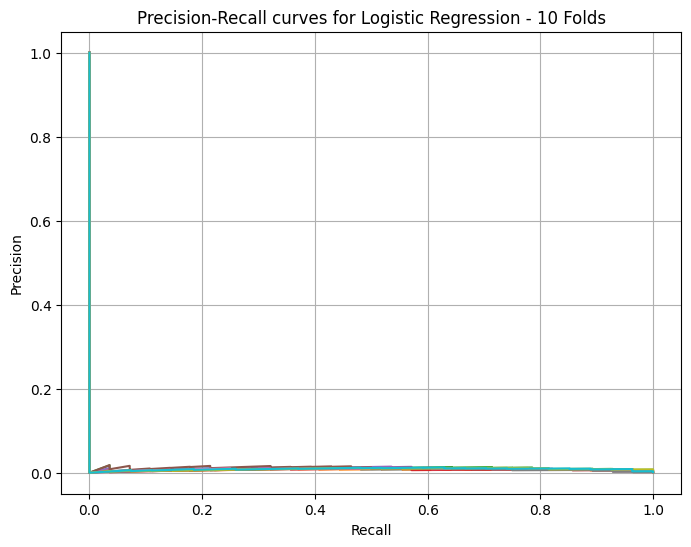

In [58]:
plot_precision_recall_curve(lr_probs, [y_test for _, y_test in test_folds], "Precision-Recall curves for Logistic Regression - 10 Folds")

##### Accuracy comparison between the two models - 10 Folds

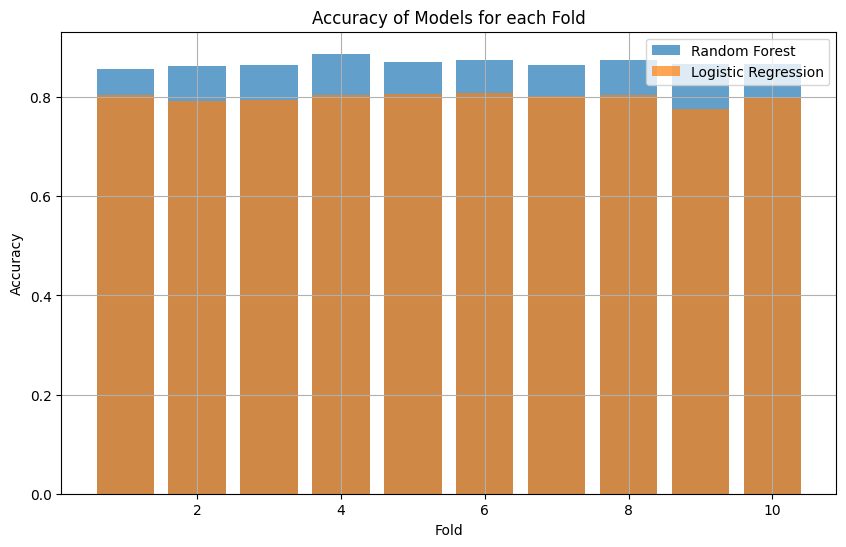

In [57]:
# bar plot of accuracies for each fold
# comparing the two models
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), rf_accuracies, alpha=0.7, label='Random Forest')
plt.bar(range(1, 11), lr_accuracies, alpha=0.7, label='Logistic Regression')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy of Models for each Fold')
plt.legend()
plt.grid()
plt.show()

### 4b. Explain the applied data pre-processing steps, learning algorithms, and post-processing steps or ensemble methods. Compare the performance of the two algorithms, focusing on performance criteria that are relevant in practice, use 10-fold cross-validation.

Our **preprocessing** (as shown in the beginning of the notebook - W1_Visuals.ipynb) mainly comprises of cleaning the data (NaN values, etc.) and encoding the categorical data into numbers, so that they can be analyzed more easily and utilized by classifiers. Then, we use a MinMax scaler for our numerical (and some encoded categorical) data. By mapping the feature values between 0 and 1, classifiers can process them more effectively and achieve better performance.

After implementing and applying 10-fold cross-validation, we either do SMOTE for synthesizing fraudulent samples or under-sampling, depending on our computation and performance preferences, for the training data.Since we have a heavily imbalanced dataset, this process will help our classifiers treat both classes equally and truly attempt to learn underlying relationships to achieve good performance. 

Our black-box model is Random Forest (RF), while our white-box model is Logistic Regression (LR), selected after experiments in our individual parts. Because of the nature of this task, accuracy is not a useful comparison metric, nevertheless we compute it for each fold, where RF clearly outperforms LR. So, we mainly focus on AUC scores.RF achieves 0.94858, much better than 0.89814 for LR. This is normal, as RF is using 100 estimators and can easily learn hidden relationships. However, LR performs quite well with the additional benefit of having explainable coefficients, which can give us insights on how it makes a decision. Finally, both models have equally bad precisions, as it is difficult to single out fraudulent transactions. Overall, the preferences of the users will determine the type of model to be used.

## 5. Bonus task – 1 A4

### 5a. Provide code and report below

In [60]:
# read the train data
df = pd.read_csv(train_path)
df.head()

,Id,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label
0,1,GB,mccredit,546097.0,4500.0,GBP,GB,Ecommerce,True,1,UKAccount,email132571,ip123779,card250169,0
1,2,GB,mcdebit,557349.0,3395.0,GBP,GB,Ecommerce,True,1,UKAccount,email312302,ip298387,card14235,0
2,3,GB,mccredit,542011.0,3895.0,GBP,GB,Ecommerce,True,1,UKAccount,email255027,ip260053,card31944,0
3,4,GB,visadebit,465943.0,15345.0,GBP,GB,ContAuth,False,0,UKAccount,email283167,ip54851,card120871,0
4,6,GB,visadebit,475127.0,5095.0,GBP,GB,Ecommerce,True,1,UKAccount,email325263,ip203929,card208017,0


In [61]:
# Prepare card id and ip id for plotting
# Preprocessing pipeline adjusted from W1_Visuals.ipynb

# 1.Card ID
card_enc = LabelEncoder()
card_enc.fit(df['card_id'])
df['card_id'] = card_enc.transform(df.card_id)

# 2.IP ID
ip_enc = LabelEncoder()
ip_enc.fit(df['ip_id'])
df['ip_id'] = ip_enc.transform(df.ip_id)

#Encoding, Cleaning the data
df.loc[df['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
df.loc[df['issuercountrycode'].isna(),'issuercountrycode'] = 'ZZ'
df.loc[df['shoppercountrycode'].isna(),'shoppercountrycode'] = 'ZZ'

unique_issuer_cc = df['issuercountrycode'].unique()
unique_shopper_cc = df['shoppercountrycode'].unique()
both = np.append(unique_issuer_cc, unique_shopper_cc)
df_countrycodes = pd.DataFrame(both)
unique_codes = df_countrycodes[0].unique()
enc = LabelEncoder()
enc.fit(unique_codes)
df['issuercountrycode'] = enc.transform(df.issuercountrycode)
df['shoppercountrycode'] = enc.transform(df.shoppercountrycode)
def conv(row):
    currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                     "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                     "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                     "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                     "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                     "CNY": 7.5541, "SEK": 10.635}
    return row['amount'] / (currency_dict[row['currencycode']]*100)

df['amount_eur'] = df.apply(lambda x: conv(x), axis=1)


enc1 = LabelEncoder()
enc1.fit(df['txvariantcode'])
df['txvariantcode'] = enc1.transform(df.txvariantcode)

enc2 = LabelEncoder()
enc2.fit(df['currencycode'])
df['currencycode'] = enc2.transform(df.currencycode)

enc3 = LabelEncoder()
enc3.fit(df['shopperinteraction'])
df['shopperinteraction'] = enc3.transform(df.shopperinteraction)

df['accountcode'] = df['accountcode'].apply(lambda x: re.sub('Account','',x))
df['accountcode_cc'] = 0
df.loc[(df['accountcode'] == 'UK'),'accountcode_cc'] = 'GB'
df.loc[(df['accountcode'] == 'Mexico'),'accountcode_cc'] = 'MX'
df.loc[(df['accountcode'] == 'Sweden'),'accountcode_cc'] = 'SE'
df.loc[(df['accountcode'] == 'APAC'),'accountcode_cc'] = 'APAC'

enc4 = LabelEncoder()
enc4.fit(df['accountcode'])
df['accountcode'] = enc4.transform(df.accountcode)

### Better to use one-hot encoding, very few categories
enc5 = LabelEncoder()
enc5.fit(df['cardverificationcodesupplied'])
df['cardverificationcodesupplied'] = enc5.transform(df.cardverificationcodesupplied)

df.loc[df['mail_id'].str.contains('na',case=False),'mail_id'] = 'email99999'

enc6 = LabelEncoder()
enc6.fit(df['mail_id'])
df['mail_id'] = enc6.transform(df.mail_id)

df.loc[df['cvcresponsecode'] > 2,'cvcresponsecode'] = 3

#Feature Engineering
df['countries_equal'] = (df['shoppercountrycode'] == df['issuercountrycode'])
df.loc[df['countries_equal'] == False,'countries_equal'] = 0
df.loc[df['countries_equal'] == True,'countries_equal'] = 1

C:\Users\Thanos\AppData\Local\Temp\ipykernel_7760\929892654.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'GB' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df['accountcode'] == 'UK'),'accountcode_cc'] = 'GB'
C:\Users\Thanos\AppData\Local\Temp\ipykernel_7760\929892654.py:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[df['countries_equal'] == False,'countries_equal'] = 0


In [66]:
# We will do scaling just before the evaluation part -
# while we construct new features, we keep the values as they are

# create a copy of df, to use for feature engineering
df_bonus = df.copy()
df_bonus.head()

,Id,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label,amount_eur,accountcode_cc,countries_equal
0,1,49,2,546097.0,4500.0,1,49,1,1,1,3,17805,12538,105460,0,52.175123,GB,1
1,2,49,3,557349.0,3395.0,1,49,1,1,1,3,115620,107432,29882,0,39.363232,GB,1
2,3,49,2,542011.0,3895.0,1,49,1,1,1,3,84651,87293,123743,0,45.160467,GB,1
3,4,49,8,465943.0,15345.0,1,49,0,0,0,3,99845,147089,14712,0,177.917169,GB,1
4,6,49,8,475127.0,5095.0,1,49,1,1,1,3,122624,56390,75841,0,59.073834,GB,1


##### Extracting aggregate features

In [64]:
# function to add aggregate features to the dataframe
def aggregate_features(df_bonus):
    # FEATURE 1: Number of transactions per card

    # compute number of times each card is used 
    card_use = df_bonus.groupby('card_id').size()
    df_bonus['card_frequency'] = df_bonus['card_id'].map(card_use)

    # FEATURE 2: Total amount spent by each card

    # compute total amount spent by each card
    card_amount = df_bonus.groupby('card_id')['amount_eur'].sum()
    df_bonus['card_total_amount'] = df_bonus['card_id'].map(card_amount)

    # FEATURE 3: Number of transactions per IP address

    # compute number of times each IP address is used
    ip_use = df_bonus.groupby('ip_id').size()
    df_bonus['ip_frequency'] = df_bonus['ip_id'].map(ip_use)

    # FEATURE 4: Total amount spent by each IP address

    # compute total amount spent by each IP address
    ip_amount = df_bonus.groupby('ip_id')['amount_eur'].sum()
    df_bonus['ip_total_amount'] = df_bonus['ip_id'].map(ip_amount)

    # FEATURE 5: Number of transactions per mail address

    # compute number of times each mail address is used
    ip_use = df_bonus.groupby('mail_id').size()
    df_bonus['mail_frequency'] = df_bonus['mail_id'].map(ip_use)

    # FEATURE 6: Total amount spent by each mail address

    # compute total amount spent by each mail address
    mail_amount = df_bonus.groupby('mail_id')['amount_eur'].sum()
    df_bonus['mail_total_amount'] = df_bonus['mail_id'].map(mail_amount)

    # FEATURE 7: Total amount spent in transactions with this shopper country code

    # compute total amount spent by each card
    shopper_country_amount = df_bonus.groupby('shoppercountrycode')['amount_eur'].sum()
    df_bonus['shopper_country_total_amount'] = df_bonus['shoppercountrycode'].map(shopper_country_amount)

    # FEATURE 8: Combine 'cardverificationcodesupplied' and 'cvcresponsecode' columns
    # to create a new feature

    # assign a different value to eac combination of the two features
    df_bonus['cvc_outcome'] = 1
    df_bonus.loc[((df_bonus['cardverificationcodesupplied'] == 0) & (df_bonus['cvcresponsecode'].isin([0, 3]))), 'cvc_outcome'] = 1
    df_bonus.loc[((df_bonus['cardverificationcodesupplied'] == 0) & (df_bonus['cvcresponsecode'] == 1)), 'cvc_outcome'] = 2
    df_bonus.loc[((df_bonus['cardverificationcodesupplied'] == 0) & (df_bonus['cvcresponsecode'] == 2)), 'cvc_outcome'] = 3
    df_bonus.loc[((df_bonus['cardverificationcodesupplied'] == 1) & (df_bonus['cvcresponsecode'].isin([0, 3]))), 'cvc_outcome'] = 4
    df_bonus.loc[((df_bonus['cardverificationcodesupplied'] == 1) & (df_bonus['cvcresponsecode'] == 1)), 'cvc_outcome'] = 5
    df_bonus.loc[((df_bonus['cardverificationcodesupplied'] == 1) & (df_bonus['cvcresponsecode'] == 2)), 'cvc_outcome'] = 6

    # FEATURE 9: Combine 'cardverificationcodesupplied' and 'currencycode'
    # after the visual results of our second plot from Part 1

    # assign a different value to each combination of the two features
    df_bonus['cvc_and_currency'] = 1
    df_bonus.loc[((df_bonus['cardverificationcodesupplied'] == 0) & (df_bonus['currencycode'] == 0)), 'cvc_and_currency'] = 1
    df_bonus.loc[((df_bonus['cardverificationcodesupplied'] == 0) & (df_bonus['currencycode'] == 1)), 'cvc_and_currency'] = 2
    df_bonus.loc[((df_bonus['cardverificationcodesupplied'] == 0) & (df_bonus['currencycode'] == 2)), 'cvc_and_currency'] = 3
    df_bonus.loc[((df_bonus['cardverificationcodesupplied'] == 0) & (df_bonus['currencycode'] == 3)), 'cvc_and_currency'] = 4
    df_bonus.loc[((df_bonus['cardverificationcodesupplied'] == 1) & (df_bonus['currencycode'] == 0)), 'cvc_and_currency'] = 5
    df_bonus.loc[((df_bonus['cardverificationcodesupplied'] == 1) & (df_bonus['currencycode'] == 1)), 'cvc_and_currency'] = 6
    df_bonus.loc[((df_bonus['cardverificationcodesupplied'] == 1) & (df_bonus['currencycode'] == 2)), 'cvc_and_currency'] = 7
    df_bonus.loc[((df_bonus['cardverificationcodesupplied'] == 1) & (df_bonus['currencycode'] == 3)), 'cvc_and_currency'] = 8

    # FEATURE 10: Combine 'shopperinteraction' and 'txvariantcode' columns
    # to create a new feature, for the combination of type of interaction and card

    # assign a different value to each combination of the two features
    df_bonus['interaction_and_card'] = 1
    for i in range(3):
        for j in range(13):
            df_bonus.loc[((df_bonus['txvariantcode'] == j) & (df_bonus['shopperinteraction'] == i)), 'interaction_and_card'] = i*13 + j + 1

    return df_bonus

In [67]:
# add new features to the dataframe
df_bonus = aggregate_features(df_bonus)

# check new feature
df_bonus.head()

,Id,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,...,card_frequency,card_total_amount,ip_frequency,ip_total_amount,mail_frequency,mail_total_amount,shopper_country_total_amount,cvc_outcome,cvc_and_currency,interaction_and_card
0,1,49,2,546097.0,4500.0,1,49,1,1,1,...,1,52.175123,3,171.482237,1,52.175123,1.075376e+07,5,6,16
1,2,49,3,557349.0,3395.0,1,49,1,1,1,...,1,39.363232,1,39.363232,1,39.363232,1.075376e+07,5,6,17
2,3,49,2,542011.0,3895.0,1,49,1,1,1,...,1,45.160467,1,45.160467,1,45.160467,1.075376e+07,5,6,16
3,4,49,8,465943.0,15345.0,1,49,0,0,0,...,3,206.207680,3,206.207680,3,206.207680,1.075376e+07,1,2,9
4,6,49,8,475127.0,5095.0,1,49,1,1,1,...,1,59.073834,1,59.073834,1,59.073834,1.075376e+07,5,6,22


In [68]:
# Scaling features with MinMaxScaler

scaler = MinMaxScaler()
df_bonus[['bin', 'amount', 'amount_eur', 'mail_id', 'ip_id', 'card_id', 'card_frequency', 'card_total_amount', 'ip_frequency', 
          'ip_total_amount', 'mail_frequency', 'mail_total_amount', 'shopper_country_total_amount']] = scaler.fit_transform(df_bonus[['bin', 
          'amount', 'amount_eur', 'mail_id', 'ip_id', 'card_id', 'card_frequency', 'card_total_amount', 'ip_frequency', 
          'ip_total_amount', 'mail_frequency', 'mail_total_amount', 'shopper_country_total_amount']])

df_bonus.head()

,Id,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,...,card_frequency,card_total_amount,ip_frequency,ip_total_amount,mail_frequency,mail_total_amount,shopper_country_total_amount,cvc_outcome,cvc_and_currency,interaction_and_card
0,1,49,2,0.915256,0.002275,1,49,1,1,1,...,0.000000,0.007208,0.005435,0.006973,0.000000,0.002696,1.0,5,6,16
1,2,49,3,0.985768,0.001710,1,49,1,1,1,...,0.000000,0.005428,0.000000,0.001591,0.000000,0.002030,1.0,5,6,17
2,3,49,2,0.889650,0.001966,1,49,1,1,1,...,0.000000,0.006233,0.000000,0.001827,0.000000,0.002331,1.0,5,6,16
3,4,49,8,0.412956,0.007821,1,49,0,0,0,...,0.022472,0.028618,0.005435,0.008388,0.007299,0.010704,1.0,1,2,9
4,6,49,8,0.470509,0.002580,1,49,1,1,1,...,0.000000,0.008167,0.000000,0.002394,0.000000,0.003055,1.0,5,6,22


##### Evaluating each aggregate feature

In [70]:
# We are using a Random Forest Classifier, as it was the best model from our experiments

# original features used for classification
existing_features = df.columns.tolist()
existing_features.remove('label')
existing_features.remove('accountcode_cc')

# new aggregate features
new_features = df_bonus.columns.tolist()
for f in existing_features:
    new_features.remove(f)
new_features.remove('label')
new_features.remove('accountcode_cc')

print('New features are: ', new_features)

# we are going to add each of the new features independently to the original features
# and evaluate performance of classifier with the new feature
for new_f in new_features:
    cols = existing_features.copy()
    cols.append(new_f)
    X = df_bonus[cols]
    y = df_bonus['label']

    # use Stratified K-Folds cross-validation to split the data into 10 folds
    skf = StratifiedKFold(n_splits=10)

    train_folds = []
    test_folds = []

    # keep train and test data for each fold, as using Startified K-Folder
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        # print(f"Fold {i+1}: Train: {len(train_index)}, Test: {len(test_index)}")
        train_folds.append((X.iloc[train_index], y.iloc[train_index]))
        test_folds.append((X.iloc[test_index], y.iloc[test_index]))

    # NOTE: Using SMOTE to synthesize data will require longer training times
    # again, here you can either choose RandomUnderSampler for faster results
    # perform oversampling on the training data
    for i, (X_train, y_train) in enumerate(train_folds):
        # sampler = SMOTE(random_state=42)
        sampler = RandomUnderSampler(random_state=42)
        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
        train_folds[i] = (X_resampled, y_resampled)

    auc_scores = []

    # iterate for each cross-validation fold
    for i, (X_train, y_train) in enumerate(train_folds):
        
        clf = RandomForestClassifier(random_state=42)

        # fit the model
        X_test, y_test = test_folds[i]
        clf.fit(X_train, y_train)

        # calculate probabilities of fraudulent transactions for AUC score
        y_probs = clf.predict_proba(X_test)[:, 1]

        
        # Compute the ROC curve and AUC score
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        auc_scores.append(auc(fpr, tpr))

    print("Added feature: ", new_f)
    print(f"Mean AUC: {np.mean(auc_scores):.5f}")

    
    

New features are:  ['card_frequency', 'card_total_amount', 'ip_frequency', 'ip_total_amount', 'mail_frequency', 'mail_total_amount', 'shopper_country_total_amount', 'cvc_outcome', 'cvc_and_currency', 'interaction_and_card']
Added feature:  card_frequency
Mean AUC: 0.95091
Added feature:  card_total_amount
Mean AUC: 0.95107
Added feature:  ip_frequency
Mean AUC: 0.95026
Added feature:  ip_total_amount
Mean AUC: 0.94941
Added feature:  mail_frequency
Mean AUC: 0.94897
Added feature:  mail_total_amount
Mean AUC: 0.94972
Added feature:  shopper_country_total_amount
Mean AUC: 0.94694
Added feature:  cvc_outcome
Mean AUC: 0.94577
Added feature:  cvc_and_currency
Mean AUC: 0.94724
Added feature:  interaction_and_card
Mean AUC: 0.94805


For the Bonus part, we used many aggregates. We computed frequency of identifiers, money per identifier and combining features. We can see an larger AUC score improvement (0.0015-0.0025) for features more specific to the transaction, such as card and IP frequency and amounts transacted. The other aggregate features lead to marginal improvement or deterioration, since they don't seem to be discriminative of fraudulent and clean transactions. 

## Kaggle Competition

In [61]:
# preprocess test data
df_test = pd.read_csv(test_path)

#Prepare card id and ip id for plotting

# 1.Card ID
card_enc = LabelEncoder()
card_enc.fit(df_test['card_id'])
df_test['card_id'] = card_enc.transform(df_test.card_id)

# 2.IP ID
ip_enc = LabelEncoder()
ip_enc.fit(df_test['ip_id'])
df_test['ip_id'] = ip_enc.transform(df_test.ip_id)

#Encoding, Cleaning the data
df_test.loc[df_test['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
df_test.loc[df_test['issuercountrycode'].isna(),'issuercountrycode'] = 'ZZ'
df_test.loc[df_test['shoppercountrycode'].isna(),'shoppercountrycode'] = 'ZZ'

unique_issuer_cc = df_test['issuercountrycode'].unique()
unique_shopper_cc = df_test['shoppercountrycode'].unique()
both = np.append(unique_issuer_cc, unique_shopper_cc)
df_countrycodes = pd.DataFrame(both)
unique_codes = df_countrycodes[0].unique()
enc = LabelEncoder()
enc.fit(unique_codes)
df_test['issuercountrycode'] = enc.transform(df_test.issuercountrycode)
df_test['shoppercountrycode'] = enc.transform(df_test.shoppercountrycode)
def conv(row):
    currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                     "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                     "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                     "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                     "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                     "CNY": 7.5541, "SEK": 10.635}
    return row['amount'] / (currency_dict[row['currencycode']]*100)

df_test['amount_eur'] = df_test.apply(lambda x: conv(x), axis=1)


enc1 = LabelEncoder()
enc1.fit(df_test['txvariantcode'])
df_test['txvariantcode'] = enc1.transform(df_test.txvariantcode)

enc2 = LabelEncoder()
enc2.fit(df_test['currencycode'])
df_test['currencycode'] = enc2.transform(df_test.currencycode)

enc3 = LabelEncoder()
enc3.fit(df_test['shopperinteraction'])
df_test['shopperinteraction'] = enc3.transform(df_test.shopperinteraction)

df_test['accountcode'] = df_test['accountcode'].apply(lambda x: re.sub('Account','',x))
df_test['accountcode_cc'] = 0
df_test.loc[(df_test['accountcode'] == 'UK'),'accountcode_cc'] = 'GB'
df_test.loc[(df_test['accountcode'] == 'Mexico'),'accountcode_cc'] = 'MX'
df_test.loc[(df_test['accountcode'] == 'Sweden'),'accountcode_cc'] = 'SE'
df_test.loc[(df_test['accountcode'] == 'APAC'),'accountcode_cc'] = 'APAC'

enc4 = LabelEncoder()
enc4.fit(df_test['accountcode'])
df_test['accountcode'] = enc4.transform(df_test.accountcode)

### Better to use one-hot encoding, very few categories
enc5 = LabelEncoder()
enc5.fit(df_test['cardverificationcodesupplied'])
df_test['cardverificationcodesupplied'] = enc5.transform(df_test.cardverificationcodesupplied)

df_test.loc[df_test['mail_id'].str.contains('na',case=False),'mail_id'] = 'email99999'

enc6 = LabelEncoder()
enc6.fit(df_test['mail_id'])
df_test['mail_id'] = enc6.transform(df_test.mail_id)

df_test.loc[df_test['cvcresponsecode'] > 2,'cvcresponsecode'] = 3

#Feature Engineering
df_test['countries_equal'] = (df_test['shoppercountrycode'] == df_test['issuercountrycode'])
df_test.loc[df_test['countries_equal'] == False,'countries_equal'] = 0
df_test.loc[df_test['countries_equal'] == True,'countries_equal'] = 1

C:\Users\Thanos\AppData\Local\Temp\ipykernel_14760\2861964316.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'GB' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_test.loc[(df_test['accountcode'] == 'UK'),'accountcode_cc'] = 'GB'
C:\Users\Thanos\AppData\Local\Temp\ipykernel_14760\2861964316.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_test.loc[df_test['countries_equal'] == False,'countries_equal'] = 0


In [62]:
df_test = aggregate_features(df_test)

# Scaling features with MinMaxScaler

scaler = MinMaxScaler()
df_test[['bin', 'amount', 'amount_eur', 'mail_id', 'ip_id', 'card_id', 'card_frequency', 'card_total_amount', 
          'ip_frequency', 'mail_frequency', 'shopper_country_total_amount']] = scaler.fit_transform(df_test[['bin', 
                    'amount', 'amount_eur', 'mail_id', 'ip_id', 'card_id', 'card_frequency', 'card_total_amount', 
          'ip_frequency', 'mail_frequency', 'shopper_country_total_amount']])

df_test.head()

,Id,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,...,accountcode_cc,countries_equal,card_frequency,card_total_amount,ip_frequency,mail_frequency,cvc_outcome,cvc_and_currency,interaction_and_card,shopper_country_total_amount
0,0,37,7,0.577445,0.000793,1,37,1,0,1,...,GB,1,0.0,0.004321,0.0,0.0,2,2,21,1.000000
1,5,37,2,0.985958,0.004225,1,37,1,1,1,...,GB,1,0.0,0.022196,0.0,0.0,5,6,16,1.000000
2,7,37,9,0.582031,0.013879,1,37,1,1,1,...,GB,1,0.0,0.072477,0.0,0.0,5,6,23,1.000000
3,9,83,7,0.590784,0.011878,3,83,1,1,0,...,APAC,1,0.0,0.031739,0.0,0.0,4,8,21,0.027889
4,16,5,1,0.744658,0.008729,0,5,1,1,0,...,APAC,1,0.0,0.024645,0.0,0.0,4,5,15,0.132813


In [69]:
# create new model instance
clf = RandomForestClassifier(random_state=42)

X = df_bonus[existing_features+['card_frequency', 'card_total_amount', 'ip_frequency']]
y = df_bonus['label']

# resample training data
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# fit on all training data
clf.fit(X_resampled, y_resampled)

X_test = df_test[existing_features+['card_frequency', 'card_total_amount', 'ip_frequency']]

# calculate probabilities of fraudulent transactions for ROC curve
y_probs = clf.predict_proba(X_test)[:, 1]

In [70]:
# save to csv - ID and y_probs
df_test['Predicted'] = y_probs
df_test[['Id', 'Predicted']].to_csv('test_predictions.csv', index=False)